# Stage 3: DFU Severity Grading (Wagner 1-4)

This notebook trains a model to classify Diabetic Foot Ulcers (DFU) into 4 severity grades:
- **Grade 1**: Superficial Diabetic Ulcer
- **Grade 2**: Ulcer Extension (Deep)
- **Grade 3**: Deep Ulcer with Abscess or Osteomyelitis
- **Grade 4**: Gangrene Detection

**Model**: EfficientNet-B0 (Pretrained)\n
**Objective**: Differentiate between severity levels to assist in triage priority.

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Setup Paths
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "severity_dfu"
TRAIN_CSV = PROJECT_ROOT / "data" / "loaders" / "dfu_severity_train.csv"
VAL_CSV = PROJECT_ROOT / "data" / "loaders" / "dfu_severity_val.csv"
MODEL_SAVE_DIR = PROJECT_ROOT / "models" / "stage3_severity"
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Config
CLASSES = ['grade_1', 'grade_2', 'grade_3', 'grade_4']
CLASS_TO_IDX = {name: i for i, name in enumerate(CLASSES)}
IMG_SIZE = 224
BATCH_SIZE = 16 # Adjust based on VRAM
EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")
print(f"Classes: {CLASSES}")

f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Classes: ['grade_1', 'grade_2', 'grade_3', 'grade_4']


## 1. Dataset & Transforms

In [2]:
class DfuSeverityDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.df = self.df[self.df['class'].isin(CLASSES)].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = CLASS_TO_IDX[row['class']]
        rel_path = str(row['path']).replace('\\', os.sep).replace('/', os.sep)
        
        # Path Resolution Strategy
        if "data" in rel_path:
             clean_path = rel_path[rel_path.find("data"):]
             img_path = PROJECT_ROOT / clean_path
        else:
             img_path = self.root_dir / rel_path
             
        try:
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)
            
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"Error: {e} at {img_path}")
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), torch.tensor(label, dtype=torch.long)

# Transforms
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Loaders
train_ds = DfuSeverityDataset(TRAIN_CSV, DATA_DIR, transform=train_transform)
val_ds = DfuSeverityDataset(VAL_CSV, DATA_DIR, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train Size: {len(train_ds)}")
print(f"Val Size: {len(val_ds)}")

Train Size: 7711
Val Size: 1928


## 2. Visualize Helper

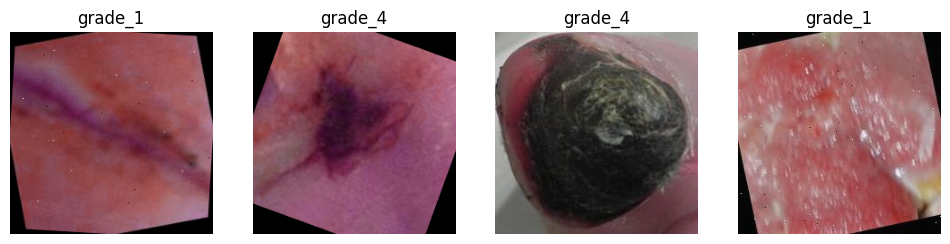

In [3]:
# Quick sanity check of a batch
tmp_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
imgs, lbls = next(iter(tmp_loader))

plt.figure(figsize=(12, 4))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    img = imgs[i].permute(1, 2, 0).numpy()
    # Un-normalize for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title(CLASSES[lbls[i].item()])
    plt.axis('off')
plt.show()

## 3. Model & Training

In [4]:
def train_model():
    model = timm.create_model('tf_efficientnet_b0', pretrained=True, num_classes=len(CLASSES))
    model = model.to(DEVICE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()
    
    best_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        
        # --- Train ---
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, leave=False)
        for imgs, lbls in pbar:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
            
        epoch_loss = running_loss / len(train_loader)
        
        # --- Val ---
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_lbls = []
        
        with torch.no_grad():
            for imgs, lbls in tqdm(val_loader, leave=False):
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                val_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_lbls.extend(lbls.cpu().numpy())
                
        val_loss /= len(val_loader)
        val_acc = accuracy_score(all_lbls, all_preds)
        val_f1 = f1_score(all_lbls, all_preds, average='weighted')
        
        print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
        
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), MODEL_SAVE_DIR / "best_model.pth")
            print("🔥 Saved Best Model")
            
    return history, model

# Run
history, model = train_model()

C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 1.2756 | Val Loss: 0.7974 | Acc: 0.6914 | F1: 0.6902
🔥 Saved Best Model

Epoch 2/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.7543 | Val Loss: 0.5015 | Acc: 0.8164 | F1: 0.8157
🔥 Saved Best Model

Epoch 3/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.5175 | Val Loss: 0.2856 | Acc: 0.8973 | F1: 0.8977
🔥 Saved Best Model

Epoch 4/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.3817 | Val Loss: 0.2108 | Acc: 0.9279 | F1: 0.9277
🔥 Saved Best Model

Epoch 5/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.2597 | Val Loss: 0.1234 | Acc: 0.9611 | F1: 0.9611
🔥 Saved Best Model

Epoch 6/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.1940 | Val Loss: 0.1001 | Acc: 0.9751 | F1: 0.9751
🔥 Saved Best Model

Epoch 7/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.1627 | Val Loss: 0.1020 | Acc: 0.9715 | F1: 0.9715

Epoch 8/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.1222 | Val Loss: 0.0763 | Acc: 0.9777 | F1: 0.9776
🔥 Saved Best Model

Epoch 9/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.1182 | Val Loss: 0.0604 | Acc: 0.9844 | F1: 0.9844
🔥 Saved Best Model

Epoch 10/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0886 | Val Loss: 0.0675 | Acc: 0.9824 | F1: 0.9823

Epoch 11/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0801 | Val Loss: 0.0621 | Acc: 0.9824 | F1: 0.9823

Epoch 12/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0809 | Val Loss: 0.0377 | Acc: 0.9886 | F1: 0.9886
🔥 Saved Best Model

Epoch 13/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0636 | Val Loss: 0.0336 | Acc: 0.9891 | F1: 0.9891
🔥 Saved Best Model

Epoch 14/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0669 | Val Loss: 0.0393 | Acc: 0.9860 | F1: 0.9860

Epoch 15/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0518 | Val Loss: 0.0392 | Acc: 0.9901 | F1: 0.9901
🔥 Saved Best Model

Epoch 16/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0529 | Val Loss: 0.0311 | Acc: 0.9922 | F1: 0.9922
🔥 Saved Best Model

Epoch 17/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0487 | Val Loss: 0.0386 | Acc: 0.9912 | F1: 0.9912

Epoch 18/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0505 | Val Loss: 0.0365 | Acc: 0.9865 | F1: 0.9865

Epoch 19/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.0474 | Val Loss: 0.0696 | Acc: 0.9865 | F1: 0.9864

Epoch 20/20


  0%|          | 0/482 [00:00<?, ?it/s]C:\Users\Aly\AppData\Local\Temp\ipykernel_39868\3232778128.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                                

Train Loss: 0.0442 | Val Loss: 0.0464 | Acc: 0.9881 | F1: 0.9881


## 4. Evaluation Metrics

100%|██████████| 121/121 [00:04<00:00, 24.44it/s]


              precision    recall  f1-score   support

     grade_1       0.99      1.00      0.99       448
     grade_2       0.99      0.98      0.98       469
     grade_3       0.99      1.00      0.99       549
     grade_4       1.00      1.00      1.00       462

    accuracy                           0.99      1928
   macro avg       0.99      0.99      0.99      1928
weighted avg       0.99      0.99      0.99      1928



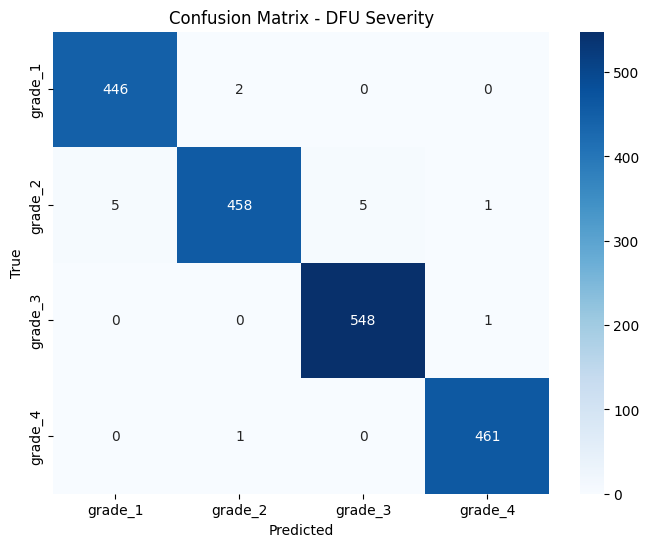

In [5]:
model.load_state_dict(torch.load(MODEL_SAVE_DIR / "best_model.pth"))
model.eval()

all_preds = []
all_lbls = []

with torch.no_grad():
    for imgs, lbls in tqdm(val_loader):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_lbls.extend(lbls.cpu().numpy())

print(classification_report(all_lbls, all_preds, target_names=CLASSES))

# Confusion Matrix
cm = confusion_matrix(all_lbls, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - DFU Severity")
plt.show()